In [1]:
import pandas as pd

# Load the data
df = pd.read_csv('processed_data/100k_population_data.csv', low_memory=False)

# Drop rows with NaN values
df.dropna(inplace=True)

# Dropping unneeded columns
dropping_columns = ['target_end_date']
df.drop(columns=dropping_columns, inplace=True)

# Exclude territories
territories_to_exclude = ['US_GU', 'US_VI', 'US_AS', 'US_PR', 'US_MP', 'US_DC']
df = df[~df['location_key'].isin(territories_to_exclude)]

# Define state lists
blue_states_list = ['US_CA', 'US_ME', 'US_OR', 'US_CO', 'US_MD', 'US_RI', 'US_CT', 'US_MA', 'US_VT', 'US_DE', 'US_NH', 'US_VA', 'US_NJ', 'US_WA', 'US_HI', 'US_NM', 'US_NY', 'US_IL']
red_states_list = ['US_AL', 'US_AK', 'US_AR', 'US_ID', 'US_IN', 'US_IA', 'US_KS', 'US_KY', 'US_LA', 'US_MS', 'US_MO', 'US_MT', 'US_NE', 'US_ND', 'US_OK', 'US_SC', 'US_SD', 'US_TN', 'US_TX', 'US_UT', 'US_WV', 'US_WY']
swing_states_list = ['US_AZ', 'US_NV', 'US_FL', 'US_NC', 'US_GA', 'US_OH', 'US_MI', 'US_PA', 'US_MN', 'US_WI']

# Create dummy variables for state types
df['blue_states'] = df['location_key'].apply(lambda x: 1 if x in blue_states_list else 0)
df['red_states'] = df['location_key'].apply(lambda x: 1 if x in red_states_list else 0)
df['swing_states'] = df['location_key'].apply(lambda x: 1 if x in swing_states_list else 0)

# Create a state_type column
def get_state_type(row):
    if row['blue_states'] == 1:
        return 'Blue'
    elif row['red_states'] == 1:
        return 'Red'
    elif row['swing_states'] == 1:
        return 'Swing'
    else:
        return 'Other'

# Apply the function to create the state_type column
df['state_type'] = df.apply(get_state_type, axis=1)

# Dropping unneeded columns
dropping_columns = ['location_key', 'location', 'blue_states', 'red_states', 'swing_states', 'unemployment_rate', 'hospitalized_per_100k']
df.drop(columns=dropping_columns, inplace=True)

# Display final dataframe
display(df)

from imblearn.combine import SMOTEENN

# Encoding state_type column for performing Random Forest after
def encode_state_type(state):
    if state == 'Blue':
        return 0
    elif state == 'Red':
        return 1
    else: 
        return 2 # For Swing states

df['state_type_encoded'] = df['state_type'].apply(encode_state_type)

# Drop the original 'state_type' column
df.drop(columns=['state_type'], inplace=True)

# Split data into features (X) and target variable (y)
X = df.drop(columns=['state_type_encoded'])
y = df['state_type_encoded']  

# Initialize SMOTEENN for over- and under-sampling
smote_enn = SMOTEENN()

# Apply SMOTEENN to the data
X_resampled, y_resampled = smote_enn.fit_resample(X, y)

# Convert y_resampled to a DataFrame and count the number of states in each type
y_resampled_df = pd.DataFrame(y_resampled, columns=['state_type_encoded'])

# Print the number of red states, blue states, and swing states
print(y_resampled_df['state_type_encoded'].value_counts())

# Display new dataframe
display(df)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Split the resampled data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(random_state=42)

rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Cross-validation
cv = KFold(n_splits=5, random_state=42, shuffle=True)
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)

# Print evaluation metrics
print(f'R2: {r2:.4f}')
print(f'Test RMSE: {rmse:.4f}')
print(f'Cross-Validation RMSE: {cv_rmse_scores.mean():.4f} (+/- {cv_rmse_scores.std():.4f})')

,search_trends_common_cold,new_hospitalized_patients,stringency_index,new_persons_fully_vaccinated,average_temperature_celsius,inc cases,year,total_population,cases_per_100k,vaccinated_per_100k,state_type
2240,9.082857,1728.0,62.500000,12102.0,5.708730,23422.0,2021,4627047.0,506.197581,261.549105,Red
2241,9.727143,4013.0,61.110000,12494.0,8.451587,58334.0,2021,7272487.0,802.119000,171.798176,Swing
2242,6.250000,66.0,69.440000,0.0,-2.302381,1125.0,2021,647093.0,173.854454,0.000000,Blue
2243,5.881429,155.0,41.670000,2292.0,0.599206,2377.0,2021,896299.0,265.201679,255.718237,Red
2244,7.641429,2989.0,54.630000,22435.0,2.499207,42903.0,2021,9269175.0,462.856727,242.038801,Blue
...,...,...,...,...,...,...,...,...,...,...,...
6098,8.902857,334.0,36.110000,11608.0,22.776191,6536.0,2022,10913150.0,59.891049,106.367089,Swing
6099,10.401429,758.0,33.330000,10881.0,11.180952,22726.0,2022,6982740.0,325.459633,155.827082,Blue
6101,9.917143,359.0,27.780000,5160.0,9.521958,11418.0,2022,5714300.0,199.814500,90.299774,Swing
6102,9.102857,117.0,30.951429,1287.0,15.607936,1726.0,2022,1774035.0,97.292331,72.546483,Red


state_type_encoded
2    1515
1    1482
0    1479
Name: count, dtype: int64


,search_trends_common_cold,new_hospitalized_patients,stringency_index,new_persons_fully_vaccinated,average_temperature_celsius,inc cases,year,total_population,cases_per_100k,vaccinated_per_100k,state_type_encoded
2240,9.082857,1728.0,62.500000,12102.0,5.708730,23422.0,2021,4627047.0,506.197581,261.549105,1
2241,9.727143,4013.0,61.110000,12494.0,8.451587,58334.0,2021,7272487.0,802.119000,171.798176,2
2242,6.250000,66.0,69.440000,0.0,-2.302381,1125.0,2021,647093.0,173.854454,0.000000,0
2243,5.881429,155.0,41.670000,2292.0,0.599206,2377.0,2021,896299.0,265.201679,255.718237,1
2244,7.641429,2989.0,54.630000,22435.0,2.499207,42903.0,2021,9269175.0,462.856727,242.038801,0
...,...,...,...,...,...,...,...,...,...,...,...
6098,8.902857,334.0,36.110000,11608.0,22.776191,6536.0,2022,10913150.0,59.891049,106.367089,2
6099,10.401429,758.0,33.330000,10881.0,11.180952,22726.0,2022,6982740.0,325.459633,155.827082,0
6101,9.917143,359.0,27.780000,5160.0,9.521958,11418.0,2022,5714300.0,199.814500,90.299774,2
6102,9.102857,117.0,30.951429,1287.0,15.607936,1726.0,2022,1774035.0,97.292331,72.546483,1


R2: 0.9899
Test RMSE: 0.0828
Cross-Validation RMSE: 0.0685 (+/- 0.0229)


In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from imblearn.combine import SMOTEENN

# Load the data
df = pd.read_csv('processed_data/100k_population_data.csv', low_memory=False)

# Drop rows with NaN values
df.dropna(inplace=True)

# Dropping unneeded columns
dropping_columns = ['target_end_date']
df.drop(columns=dropping_columns, inplace=True)

# Exclude territories
territories_to_exclude = ['US_GU', 'US_VI', 'US_AS', 'US_PR', 'US_MP', 'US_DC']
df = df[~df['location_key'].isin(territories_to_exclude)]

# Define state lists
blue_states_list = ['US_CA', 'US_ME', 'US_OR', 'US_CO', 'US_MD', 'US_RI', 'US_CT', 'US_MA', 'US_VT', 'US_DE', 'US_NH', 'US_VA', 'US_NJ', 'US_WA', 'US_HI', 'US_NM', 'US_NY', 'US_IL']
red_states_list = ['US_AL', 'US_AK', 'US_AR', 'US_ID', 'US_IN', 'US_IA', 'US_KS', 'US_KY', 'US_LA', 'US_MS', 'US_MO', 'US_MT', 'US_NE', 'US_ND', 'US_OK', 'US_SC', 'US_SD', 'US_TN', 'US_TX', 'US_UT', 'US_WV', 'US_WY']
swing_states_list = ['US_AZ', 'US_NV', 'US_FL', 'US_NC', 'US_GA', 'US_OH', 'US_MI', 'US_PA', 'US_MN', 'US_WI']

# Create dummy variables for state types
df['blue_states'] = df['location_key'].apply(lambda x: 1 if x in blue_states_list else 0)
df['red_states'] = df['location_key'].apply(lambda x: 1 if x in red_states_list else 0)
df['swing_states'] = df['location_key'].apply(lambda x: 1 if x in swing_states_list else 0)

# Create a state_type column
def get_state_type(row):
    if row['blue_states'] == 1:
        return 'Blue'
    elif row['red_states'] == 1:
        return 'Red'
    elif row['swing_states'] == 1:
        return 'Swing'
    else:
        return 'Other'

# Apply the function to create the state_type column
df['state_type'] = df.apply(get_state_type, axis=1)

# Dropping unneeded columns
dropping_columns = ['location_key', 'location', 'blue_states', 'red_states', 'swing_states', 'unemployment_rate', 'hospitalized_per_100k']
df.drop(columns=dropping_columns, inplace=True)

# Display final dataframe
display(df)

# Encoding state_type column for performing Random Forest after
def encode_state_type(state):
    if state == 'Blue':
        return 0
    elif state == 'Red':
        return 1
    else: 
        return 2 # For Swing states

df['state_type_encoded'] = df['state_type'].apply(encode_state_type)

# Drop the original 'state_type' column
df.drop(columns=['state_type'], inplace=True)

# Split data into features (X) and target variable (y)
X = df.drop(columns=['state_type_encoded'])
y = df['state_type_encoded']  

# Initialize SMOTEENN for over- and under-sampling
smote_enn = SMOTEENN()

# Apply SMOTEENN to the data
X_resampled, y_resampled = smote_enn.fit_resample(X, y)

# Convert y_resampled to a DataFrame and count the number of states in each type
y_resampled_df = pd.DataFrame(y_resampled, columns=['state_type_encoded'])

# Print the number of red states, blue states, and swing states
print(y_resampled_df['state_type_encoded'].value_counts())

# Display new dataframe
display(df)

# Split the resampled data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Cross-validation
cv = KFold(n_splits=5, random_state=42, shuffle=True)
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)

# Print evaluation metrics
print(f'R2: {r2:.4f}')
print(f'Test RMSE: {rmse:.4f}')
print(f'Cross-Validation RMSE: {cv_rmse_scores.mean():.4f} (+/- {cv_rmse_scores.std():.4f})')

# Statistical Tests
results_df = pd.DataFrame({'State_Type': y_test, 'Predicted': y_pred, 'Residuals': y_test - y_pred})
anova_results = stats.f_oneway(
    results_df[results_df['State_Type'] == 0]['Residuals'],
    results_df[results_df['State_Type'] == 1]['Residuals'],
    results_df[results_df['State_Type'] == 2]['Residuals']
)
print(f'ANOVA F-value: {anova_results.statistic:.4f}, p-value: {anova_results.pvalue:.4f}')

# Fairness Metrics
# Demographic Parity
y_test_df = pd.DataFrame({'state_type': y_test, 'predicted': y_pred})
demographic_parity = y_test_df.groupby('state_type')['predicted'].mean().reset_index()
demographic_parity.columns = ['State Type', 'Mean Predicted Value']
print("\nDemographic Parity:")
print(demographic_parity)

# Equalized Odds (Residuals)
residuals_by_state_type = results_df.groupby('State_Type')['Residuals'].apply(list).reset_index()
residuals_by_state_type['Mean Residual'] = residuals_by_state_type['Residuals'].apply(np.mean)
residuals_by_state_type['Std Residual'] = residuals_by_state_type['Residuals'].apply(np.std)
print("\nEqualized Odds (Residuals):")
print(residuals_by_state_type[['State_Type', 'Mean Residual', 'Std Residual']])

# Add the 'cases_per_100k' column to the y_test_df
y_test_df['cases_per_100k'] = X_test['cases_per_100k']

# Predictive Parity (Mean Absolute Error)
mae_by_state_type = y_test_df.groupby('state_type').apply(lambda x: mean_absolute_error(x['cases_per_100k'], x['predicted'])).reset_index()
mae_by_state_type.columns = ['State Type', 'MAE']
print("\nPredictive Parity (Mean Absolute Error):")
print(mae_by_state_type)

# Count data points for each state type
data_points_count = df['state_type_encoded'].value_counts().reset_index()
data_points_count.columns = ['State Type', 'Counts']
print("\nData Points Count by State Type:")
print(data_points_count)

# Check for overfitting or underfitting
train_pred = rf_model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {rmse:.4f}')

,search_trends_common_cold,new_hospitalized_patients,stringency_index,new_persons_fully_vaccinated,average_temperature_celsius,inc cases,year,total_population,cases_per_100k,vaccinated_per_100k,state_type
2240,9.082857,1728.0,62.500000,12102.0,5.708730,23422.0,2021,4627047.0,506.197581,261.549105,Red
2241,9.727143,4013.0,61.110000,12494.0,8.451587,58334.0,2021,7272487.0,802.119000,171.798176,Swing
2242,6.250000,66.0,69.440000,0.0,-2.302381,1125.0,2021,647093.0,173.854454,0.000000,Blue
2243,5.881429,155.0,41.670000,2292.0,0.599206,2377.0,2021,896299.0,265.201679,255.718237,Red
2244,7.641429,2989.0,54.630000,22435.0,2.499207,42903.0,2021,9269175.0,462.856727,242.038801,Blue
...,...,...,...,...,...,...,...,...,...,...,...
6098,8.902857,334.0,36.110000,11608.0,22.776191,6536.0,2022,10913150.0,59.891049,106.367089,Swing
6099,10.401429,758.0,33.330000,10881.0,11.180952,22726.0,2022,6982740.0,325.459633,155.827082,Blue
6101,9.917143,359.0,27.780000,5160.0,9.521958,11418.0,2022,5714300.0,199.814500,90.299774,Swing
6102,9.102857,117.0,30.951429,1287.0,15.607936,1726.0,2022,1774035.0,97.292331,72.546483,Red


state_type_encoded
2    1516
0    1481
1    1480
Name: count, dtype: int64


,search_trends_common_cold,new_hospitalized_patients,stringency_index,new_persons_fully_vaccinated,average_temperature_celsius,inc cases,year,total_population,cases_per_100k,vaccinated_per_100k,state_type_encoded
2240,9.082857,1728.0,62.500000,12102.0,5.708730,23422.0,2021,4627047.0,506.197581,261.549105,1
2241,9.727143,4013.0,61.110000,12494.0,8.451587,58334.0,2021,7272487.0,802.119000,171.798176,2
2242,6.250000,66.0,69.440000,0.0,-2.302381,1125.0,2021,647093.0,173.854454,0.000000,0
2243,5.881429,155.0,41.670000,2292.0,0.599206,2377.0,2021,896299.0,265.201679,255.718237,1
2244,7.641429,2989.0,54.630000,22435.0,2.499207,42903.0,2021,9269175.0,462.856727,242.038801,0
...,...,...,...,...,...,...,...,...,...,...,...
6098,8.902857,334.0,36.110000,11608.0,22.776191,6536.0,2022,10913150.0,59.891049,106.367089,2
6099,10.401429,758.0,33.330000,10881.0,11.180952,22726.0,2022,6982740.0,325.459633,155.827082,0
6101,9.917143,359.0,27.780000,5160.0,9.521958,11418.0,2022,5714300.0,199.814500,90.299774,2
6102,9.102857,117.0,30.951429,1287.0,15.607936,1726.0,2022,1774035.0,97.292331,72.546483,1


R2: 0.9987
Test RMSE: 0.0295
Cross-Validation RMSE: 0.0517 (+/- 0.0146)
ANOVA F-value: 29.6279, p-value: 0.0000

Demographic Parity:
   State Type  Mean Predicted Value
0           0              0.009142
1           1              0.992355
2           2              1.995200

Equalized Odds (Residuals):
   State_Type  Mean Residual  Std Residual
0           0      -0.009142      0.027152
1           1       0.007645      0.030383
2           2       0.004800      0.028053

Predictive Parity (Mean Absolute Error):
   State Type         MAE
0           0  195.874467
1           1  317.931394
2           2  263.002081

Data Points Count by State Type:
   State Type  Counts
0           1    1518
1           0    1242
2           2     690
Train RMSE: 0.0162
Test RMSE: 0.0295


,search_trends_common_cold,stringency_index,new_persons_fully_vaccinated,average_temperature_celsius,inc cases,total_population,cases_per_100k,vaccinated_per_100k,blue_states,red_states,swing_states,state_type
0,14.744286,79.630000,NaN,10.089947,2728.0,7724566.0,35.315900,NaN,1,0,0,Blue
1,16.530000,64.418571,NaN,14.730159,1374.0,7186683.0,19.118695,NaN,0,0,1,Swing
2,16.725714,87.960000,NaN,6.176367,362.0,1849339.0,19.574562,NaN,0,1,0,Red
3,17.327143,82.410000,NaN,8.069665,1543.0,1096444.0,140.727661,NaN,1,0,0,Blue
4,17.478571,78.700000,NaN,9.071429,6234.0,3577586.0,174.251576,NaN,1,0,0,Blue
...,...,...,...,...,...,...,...,...,...,...,...,...
6098,8.902857,36.110000,11608.0,22.776191,6536.0,10913150.0,59.891049,106.367089,0,0,1,Swing
6099,10.401429,33.330000,10881.0,11.180952,22726.0,6982740.0,325.459633,155.827082,1,0,0,Blue
6101,9.917143,27.780000,5160.0,9.521958,11418.0,5714300.0,199.814500,90.299774,0,0,1,Swing
6102,9.102857,30.951429,1287.0,15.607936,1726.0,1774035.0,97.292331,72.546483,0,1,0,Red


Stratified sample:


C:\Users\kalei\AppData\Local\Temp\ipykernel_28796\2200973171.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sample_df = pd.concat([sample_df, stratum_sample])


,search_trends_common_cold,stringency_index,new_persons_fully_vaccinated,average_temperature_celsius,inc cases,total_population,cases_per_100k,vaccinated_per_100k,blue_states,red_states,swing_states,state_type
3408,8.115714,69.440000,8247.0,25.142857,392.0,1446745.0,27.095307,570.038258,1,0,0,Blue
1777,6.055714,62.831429,NaN,11.619841,16566.0,6997713.0,236.734487,NaN,1,0,0,Blue
1400,6.370000,53.240000,NaN,18.261905,3866.0,6173689.0,62.620582,NaN,1,0,0,Blue
1193,5.731429,64.350000,NaN,25.665675,34574.0,39503200.0,87.522024,NaN,1,0,0,Blue
4635,10.898571,32.410000,11980.0,8.161905,2386.0,3603691.0,66.209894,332.436938,1,0,0,Blue
...,...,...,...,...,...,...,...,...,...,...,...,...
2338,8.912857,62.500000,11372.0,12.946825,15402.0,4627047.0,332.868890,245.772304,0,1,0,Red
1163,7.530000,54.630000,NaN,26.550794,5954.0,5132151.0,116.013734,NaN,0,1,0,Red
4819,13.072857,29.630000,136568.0,5.399206,8918.0,1785249.0,499.538160,7649.801232,0,1,0,Red
3615,6.928571,30.560000,11062.0,22.329365,345.0,1785249.0,19.325035,619.633452,0,1,0,Red


R2: 0.9329
Test RMSE: 106.0019
Cross-Validation RMSE: 91.1988 (+/- 15.0116)
Random Forest AIC: 2748.2474
Test MAE: 27.8955
ANOVA F-value: 1.0492922449565127
p-value: 0.3503269525638176

Demographic Parity:
    State Type  Mean Predicted Value
0           0            249.885004
1           1            272.136307
2           2            259.823423

Equalized Odds (Residuals):
   State_Type  Mean Residual  Std Residual
0           0       9.073175    149.033499
1           1      -2.924741     63.812722
2           2      12.343740     72.811169

Predictive Parity (Mean Absolute Error):
   State Type        MAE
0           0  38.460690
1           1  22.273538
2           2  19.163136

Data Points Count by State Type:
    State Type  Counts
0           1    1204
1           0     980
2           2     544


C:\Users\kalei\AppData\Local\Temp\ipykernel_28796\2200973171.py:152: FutureWarning: The provided callable <function mean at 0x000001AA2CDC1310> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  residuals_by_state_type = results_df.groupby('state_type').agg({'Residuals': [list, np.mean, np.std]}).reset_index()
C:\Users\kalei\AppData\Local\Temp\ipykernel_28796\2200973171.py:152: FutureWarning: The provided callable <function std at 0x000001AA2CDC1430> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  residuals_by_state_type = results_df.groupby('state_type').agg({'Residuals': [list, np.mean, np.std]}).reset_index()
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be re

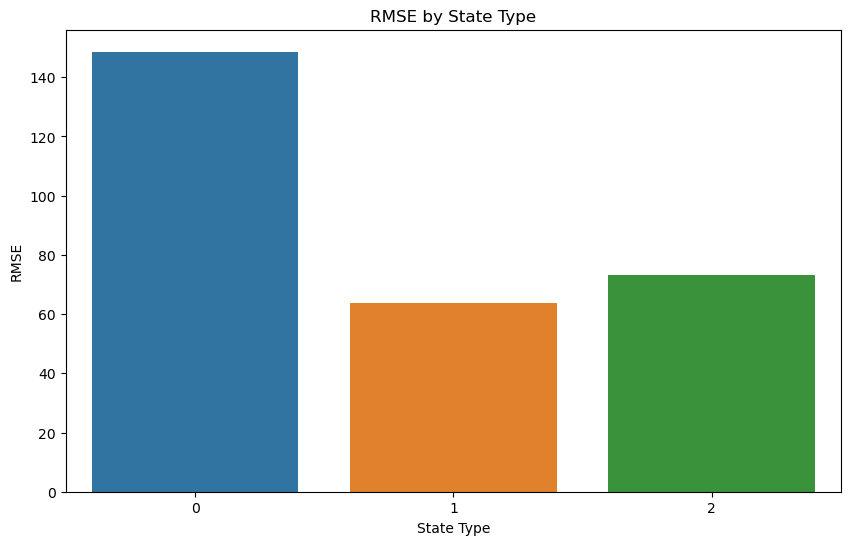


Feature Importance:
                          Feature  Importance
4                      inc cases    0.467402
5               total_population    0.241245
0      search_trends_common_cold    0.202874
3    average_temperature_celsius    0.042947
2   new_persons_fully_vaccinated    0.018237
6            vaccinated_per_100k    0.012651
1               stringency_index    0.009225
7                    blue_states    0.001894
10                    state_type    0.001759
8                     red_states    0.001162
9                   swing_states    0.000603


c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


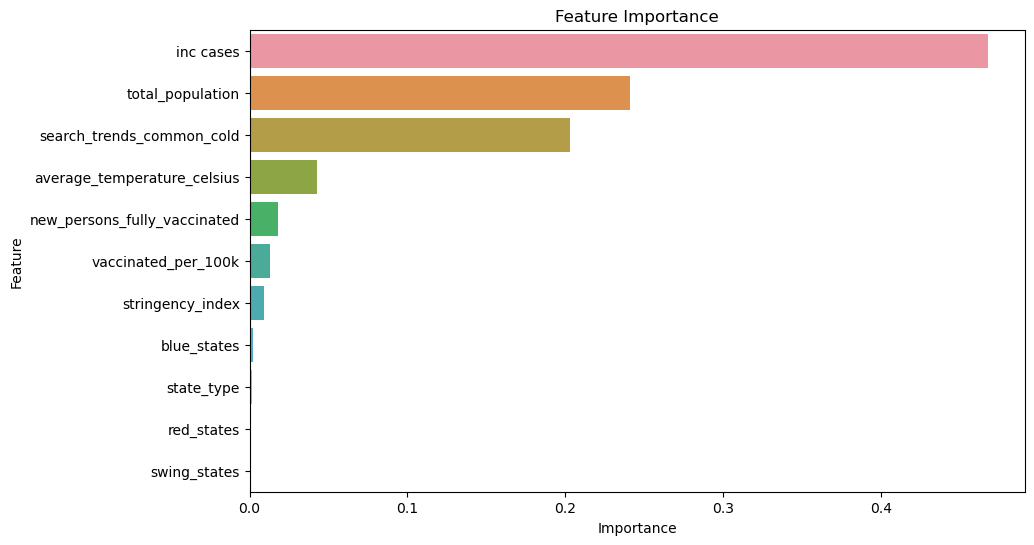

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import f_oneway

# Load dataset
df = pd.read_csv('processed_data/100k_population_data.csv', low_memory=False)

# Exclude territories
territories_to_exclude = ['US_GU', 'US_VI', 'US_AS', 'US_PR', 'US_MP', 'US_DC']
df = df[~df['location_key'].isin(territories_to_exclude)]

# Define state lists
blue_states_list = ['US_CA', 'US_ME', 'US_OR', 'US_CO', 'US_MD', 'US_RI', 'US_CT', 'US_MA', 'US_VT', 'US_DE', 'US_NH', 'US_VA', 'US_NJ', 'US_WA', 'US_HI', 'US_NM', 'US_NY', 'US_IL']
red_states_list = ['US_AL', 'US_AK', 'US_AR', 'US_ID', 'US_IN', 'US_IA', 'US_KS', 'US_KY', 'US_LA', 'US_MS', 'US_MO', 'US_MT', 'US_NE', 'US_ND', 'US_OK', 'US_SC', 'US_SD', 'US_TN', 'US_TX', 'US_UT', 'US_WV', 'US_WY']
swing_states_list = ['US_AZ', 'US_NV', 'US_FL', 'US_NC', 'US_GA', 'US_OH', 'US_MI', 'US_PA', 'US_MN', 'US_WI']

# Create dummy variables for state types
df['blue_states'] = df['location_key'].apply(lambda x: 1 if x in blue_states_list else 0)
df['red_states'] = df['location_key'].apply(lambda x: 1 if x in red_states_list else 0)
df['swing_states'] = df['location_key'].apply(lambda x: 1 if x in swing_states_list else 0)

# Create a state_type column
def get_state_type(row):
    if row['blue_states'] == 1:
        return 'Blue'
    elif row['red_states'] == 1:
        return 'Red'
    elif row['swing_states'] == 1:
        return 'Swing'
    else:
        return 'Other'

df['state_type'] = df.apply(get_state_type, axis=1)

# Drop unneeded columns
columns_to_drop = ['target_end_date', 'location_key', 'location', 'new_hospitalized_patients', 'hospitalized_per_100k', 'unemployment_rate', 'year']

# Drop the specified columns
df = df.drop(columns=columns_to_drop)

# Display dataframe
display(df)

# Define strata
strata = df['state_type'].unique()

# Perform stratified sampling
sample_df = pd.DataFrame(columns=df.columns)

for stratum in strata:
    stratum_df = df[df['state_type'] == stratum]
    stratum_size = int(0.8 * len(stratum_df))  # Adjust the sample size as needed
    stratum_sample = stratum_df.sample(n=stratum_size, random_state=42)
    sample_df = pd.concat([sample_df, stratum_sample])

# Display the stratified sample
print("Stratified sample:")
display(sample_df)

# Define encode_state_type function
def encode_state_type(state):
    if state == 'Blue':
        return 0
    elif state == 'Red':
        return 1
    else: 
        return 2 # For Swing states

sample_df['state_type'] = sample_df['state_type'].apply(encode_state_type)

sample_df.dropna(inplace=True)

# Split data into features (X) and target variable (y)
X = sample_df.drop(columns=['cases_per_100k'])
y = sample_df['cases_per_100k']  

# Training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Cross-validation
cv = KFold(n_splits=5, random_state=42, shuffle=True)
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)

# Print evaluation metrics
print(f'R2: {r2:.4f}')
print(f'Test RMSE: {rmse:.4f}')
print(f'Cross-Validation RMSE: {cv_rmse_scores.mean():.4f} (+/- {cv_rmse_scores.std():.4f})')

# Create DataFrame with actual and predicted values
y_test_df = pd.DataFrame({
    'cases_per_100k': y_test,  # Actual values
    'state_type': X_test['state_type'],  # Encoded state type
    'predicted': y_pred  # Predicted values
})

# Define a function to calculate RMSE
def calculate_rmse(group):
    return np.sqrt(mean_squared_error(group['cases_per_100k'], group['predicted']))

# Group by state type and calculate RMSE for each group
rmse_by_state_type = y_test_df.groupby('state_type').apply(calculate_rmse).reset_index()
rmse_by_state_type.columns = ['State Type', 'RMSE']

# AIC calculation
n = len(y_test)
rss = np.sum((y_test - y_pred) ** 2)
k_rf = len(rf_model.estimators_) + 1
aic_rf = n * np.log(rss / n) + 2 * k_rf
print(f'Random Forest AIC: {aic_rf:.4f}')

# Additional model evaluation metrics
test_mae = mean_absolute_error(y_test, y_pred)
print(f'Test MAE: {test_mae:.4f}')

# ANOVA F-value and p-value
f_value, p_value = f_oneway(
    sample_df[sample_df['state_type'] == 0]['cases_per_100k'],
    sample_df[sample_df['state_type'] == 1]['cases_per_100k'],
    sample_df[sample_df['state_type'] == 2]['cases_per_100k']
)
print("ANOVA F-value:", f_value)
print("p-value:", p_value)

# Demographic Parity
demographic_parity = sample_df.groupby('state_type')['cases_per_100k'].mean().reset_index()
demographic_parity.columns = ['State Type', 'Mean Predicted Value']
print("\nDemographic Parity:\n", demographic_parity)

# Equalized Odds (Residuals)
# Calculate residuals
residuals = y_test - y_pred

# Create a DataFrame with residuals and state_type
results_df = pd.DataFrame({'Residuals': residuals, 'state_type': X_test['state_type']})

# Group by state_type and calculate mean and standard deviation of residuals
residuals_by_state_type = results_df.groupby('state_type').agg({'Residuals': [list, np.mean, np.std]}).reset_index()

# Rename columns for clarity
residuals_by_state_type.columns = ['State_Type', 'Residuals', 'Mean Residual', 'Std Residual']

print("\nEqualized Odds (Residuals):")
print(residuals_by_state_type[['State_Type', 'Mean Residual', 'Std Residual']])

# Predictive Parity (Mean Absolute Error)
mae_by_state_type = y_test_df.groupby('state_type').apply(lambda x: mean_absolute_error(x['cases_per_100k'], x['predicted'])).reset_index()
mae_by_state_type.columns = ['State Type', 'MAE']
print("\nPredictive Parity (Mean Absolute Error):")
print(mae_by_state_type)

# Data Points Count by State Type
data_points_count = sample_df['state_type'].value_counts().reset_index()
data_points_count.columns = ['State Type', 'Counts']
print("\nData Points Count by State Type:\n", data_points_count)

# Plot RMSE by state type
plt.figure(figsize=(10, 6))
sns.barplot(x='State Type', y='RMSE', data=rmse_by_state_type)
plt.title('RMSE by State Type')
plt.xlabel('State Type')
plt.ylabel('RMSE')
plt.show()

# Feature importance
feature_importances = rf_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print feature importance
print("\nFeature Importance:\n", importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

,search_trends_common_cold,stringency_index,new_persons_fully_vaccinated,average_temperature_celsius,cases_per_100k,vaccinated_per_100k,state_type
0,14.744286,79.630000,NaN,10.089947,35.315900,NaN,Blue
1,16.530000,64.418571,NaN,14.730159,19.118695,NaN,Swing
2,16.725714,87.960000,NaN,6.176367,19.574562,NaN,Red
3,17.327143,82.410000,NaN,8.069665,140.727661,NaN,Blue
4,17.478571,78.700000,NaN,9.071429,174.251576,NaN,Blue
...,...,...,...,...,...,...,...
6098,8.902857,36.110000,11608.0,22.776191,59.891049,106.367089,Swing
6099,10.401429,33.330000,10881.0,11.180952,325.459633,155.827082,Blue
6101,9.917143,27.780000,5160.0,9.521958,199.814500,90.299774,Swing
6102,9.102857,30.951429,1287.0,15.607936,97.292331,72.546483,Red


Stratified sample:


C:\Users\kalei\AppData\Local\Temp\ipykernel_28796\3083404589.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sample_df = pd.concat([sample_df, stratum_sample])


,search_trends_common_cold,stringency_index,new_persons_fully_vaccinated,average_temperature_celsius,cases_per_100k,vaccinated_per_100k,state_type
3408,8.115714,69.440000,8247.0,25.142857,27.095307,570.038258,Blue
1777,6.055714,62.831429,NaN,11.619841,236.734487,NaN,Blue
1400,6.370000,53.240000,NaN,18.261905,62.620582,NaN,Blue
1193,5.731429,64.350000,NaN,25.665675,87.522024,NaN,Blue
4635,10.898571,32.410000,11980.0,8.161905,66.209894,332.436938,Blue
...,...,...,...,...,...,...,...
2338,8.912857,62.500000,11372.0,12.946825,332.868890,245.772304,Red
1163,7.530000,54.630000,NaN,26.550794,116.013734,NaN,Red
4819,13.072857,29.630000,136568.0,5.399206,499.538160,7649.801232,Red
3615,6.928571,30.560000,11062.0,22.329365,19.325035,619.633452,Red


R2: 0.5150
Test RMSE: 284.8713
Cross-Validation RMSE: 235.3274 (+/- 15.9053)
Random Forest AIC: 3288.0125
Test MAE: 139.3091
ANOVA F-value: 1.0492922449565127
p-value: 0.3503269525638176

Demographic Parity:
    State Type  Mean Predicted Value
0           0            249.885004
1           1            272.136307
2           2            259.823423

Equalized Odds (Residuals):
   State_Type  Mean Residual  Std Residual
0           0     -31.804831    309.637765
1           1     -15.923576    275.694699
2           2      12.999503    254.730504

Predictive Parity (Mean Absolute Error):
   State Type         MAE
0           0  151.520346
1           1  135.808644
2           2  122.712144

Data Points Count by State Type:
    State Type  Counts
0           1    1204
1           0     980
2           2     544

Feature Importance:
                         Feature  Importance
0     search_trends_common_cold    0.480221
3   average_temperature_celsius    0.181881
4           vaccinated_

C:\Users\kalei\AppData\Local\Temp\ipykernel_28796\3083404589.py:150: FutureWarning: The provided callable <function mean at 0x000001AA2CDC1310> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  residuals_by_state_type = results_df.groupby('state_type').agg({'Residuals': [list, np.mean, np.std]}).reset_index()
C:\Users\kalei\AppData\Local\Temp\ipykernel_28796\3083404589.py:150: FutureWarning: The provided callable <function std at 0x000001AA2CDC1430> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  residuals_by_state_type = results_df.groupby('state_type').agg({'Residuals': [list, np.mean, np.std]}).reset_index()
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be re

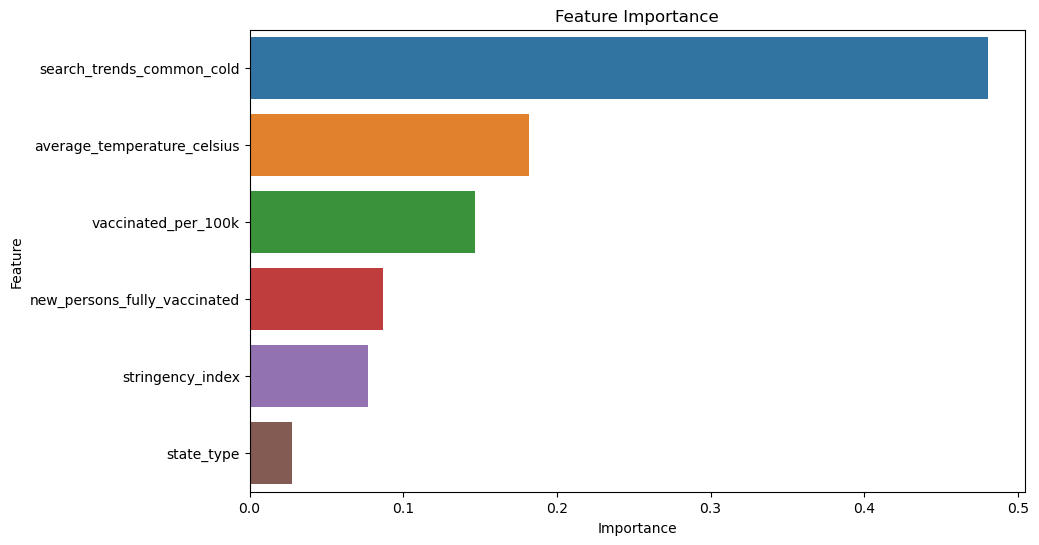

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import f_oneway

# Load dataset
df = pd.read_csv('processed_data/100k_population_data.csv', low_memory=False)

# Exclude territories
territories_to_exclude = ['US_GU', 'US_VI', 'US_AS', 'US_PR', 'US_MP', 'US_DC']
df = df[~df['location_key'].isin(territories_to_exclude)]

# Define state lists
blue_states_list = ['US_CA', 'US_ME', 'US_OR', 'US_CO', 'US_MD', 'US_RI', 'US_CT', 'US_MA', 'US_VT', 'US_DE', 'US_NH', 'US_VA', 'US_NJ', 'US_WA', 'US_HI', 'US_NM', 'US_NY', 'US_IL']
red_states_list = ['US_AL', 'US_AK', 'US_AR', 'US_ID', 'US_IN', 'US_IA', 'US_KS', 'US_KY', 'US_LA', 'US_MS', 'US_MO', 'US_MT', 'US_NE', 'US_ND', 'US_OK', 'US_SC', 'US_SD', 'US_TN', 'US_TX', 'US_UT', 'US_WV', 'US_WY']
swing_states_list = ['US_AZ', 'US_NV', 'US_FL', 'US_NC', 'US_GA', 'US_OH', 'US_MI', 'US_PA', 'US_MN', 'US_WI']

# Create dummy variables for state types
df['blue_states'] = df['location_key'].apply(lambda x: 1 if x in blue_states_list else 0)
df['red_states'] = df['location_key'].apply(lambda x: 1 if x in red_states_list else 0)
df['swing_states'] = df['location_key'].apply(lambda x: 1 if x in swing_states_list else 0)

# Create a state_type column
def get_state_type(row):
    if row['blue_states'] == 1:
        return 'Blue'
    elif row['red_states'] == 1:
        return 'Red'
    elif row['swing_states'] == 1:
        return 'Swing'
    else:
        return 'Other'

df['state_type'] = df.apply(get_state_type, axis=1)

# Drop unneeded columns
columns_to_drop = ['blue_states', 'red_states', 'swing_states', 'target_end_date', 'location_key', 'location', 'new_hospitalized_patients', 'hospitalized_per_100k', 'unemployment_rate', 'year', 'inc cases', 'total_population']

# Drop the specified columns
df = df.drop(columns=columns_to_drop)

# Displat dataframe
display(df)

# Define strata
strata = df['state_type'].unique()

# Perform stratified sampling
sample_df = pd.DataFrame(columns=df.columns)

for stratum in strata:
    stratum_df = df[df['state_type'] == stratum]
    stratum_size = int(0.8 * len(stratum_df))  # Adjust the sample size as needed
    stratum_sample = stratum_df.sample(n=stratum_size, random_state=42)
    sample_df = pd.concat([sample_df, stratum_sample])

# Display the stratifies sample
print("Stratified sample:")
display(sample_df)

# Define encode_state_type function
def encode_state_type(state):
    if state == 'Blue':
        return 0
    elif state == 'Red':
        return 1
    else: 
        return 2 # For Swing states

sample_df['state_type'] = sample_df['state_type'].apply(encode_state_type)

sample_df.dropna(inplace=True)

# Split data into features (X) and target variable (y)
X = sample_df.drop(columns=['cases_per_100k'])
y = sample_df['cases_per_100k']  

# Training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Cross-validation
cv = KFold(n_splits=5, random_state=42, shuffle=True)
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)

# Print evaluation metrics
print(f'R2: {r2:.4f}')
print(f'Test RMSE: {rmse:.4f}')
print(f'Cross-Validation RMSE: {cv_rmse_scores.mean():.4f} (+/- {cv_rmse_scores.std():.4f})')

# Create DataFrame with actual and predicted values
y_test_df = pd.DataFrame({
    'cases_per_100k': y_test,  # Actual values
    'state_type': X_test['state_type'],  # Encoded state type
    'predicted': y_pred  # Predicted values
})

# Define a function to calculate RMSE
def calculate_rmse(group):
    return np.sqrt(mean_squared_error(group['cases_per_100k'], group['predicted']))

# Group by state type and calculate RMSE for each group
rmse_by_state_type = y_test_df.groupby('state_type').apply(calculate_rmse).reset_index()
rmse_by_state_type.columns = ['State Type', 'RMSE']

# AIC calculation
n = len(y_test)
rss = np.sum((y_test - y_pred) ** 2)
k_rf = len(rf_model.estimators_) + 1
aic_rf = n * np.log(rss / n) + 2 * k_rf
print(f'Random Forest AIC: {aic_rf:.4f}')

# Additional model evaluation metrics
test_mae = mean_absolute_error(y_test, y_pred)
print(f'Test MAE: {test_mae:.4f}')

# ANOVA F-value and p-value
f_value, p_value = f_oneway(sample_df[sample_df['state_type'] == 0]['cases_per_100k'],
                             sample_df[sample_df['state_type'] == 1]['cases_per_100k'],
                             sample_df[sample_df['state_type'] == 2]['cases_per_100k'])
print("ANOVA F-value:", f_value)
print("p-value:", p_value)

# Demographic Parity
demographic_parity = sample_df.groupby('state_type')['cases_per_100k'].mean().reset_index()
demographic_parity.columns = ['State Type', 'Mean Predicted Value']
print("\nDemographic Parity:\n", demographic_parity)

# Equalized Odds (Residuals)
# Calculate residuals
residuals = y_test - y_pred

# Create a DataFrame with residuals and state_type
results_df = pd.DataFrame({'Residuals': residuals, 'state_type': X_test['state_type']})

# Group by state_type and calculate mean and standard deviation of residuals
residuals_by_state_type = results_df.groupby('state_type').agg({'Residuals': [list, np.mean, np.std]}).reset_index()

# Rename columns for clarity
residuals_by_state_type.columns = ['State_Type', 'Residuals', 'Mean Residual', 'Std Residual']

print("\nEqualized Odds (Residuals):")
print(residuals_by_state_type[['State_Type', 'Mean Residual', 'Std Residual']])

# Predictive Parity (Mean Absolute Error)
mae_by_state_type = y_test_df.groupby('state_type').apply(lambda x: mean_absolute_error(x['cases_per_100k'], x['predicted'])).reset_index()
mae_by_state_type.columns = ['State Type', 'MAE']
print("\nPredictive Parity (Mean Absolute Error):")
print(mae_by_state_type)

# Data Points Count by State Type
data_points_count = sample_df['state_type'].value_counts().reset_index()
data_points_count.columns = ['State Type', 'Counts']
print("\nData Points Count by State Type:\n", data_points_count)

# Feature importance
feature_importances = rf_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print feature importance
print("\nFeature Importance:\n", importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


Data Points Count by State Type:
    State Type  Counts
0           1    1204
1           0     980
2           2     544


c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


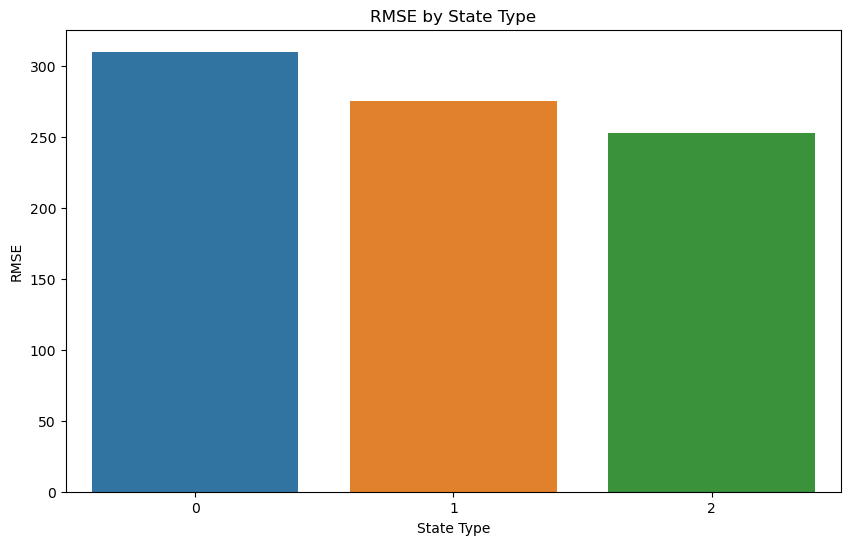

In [26]:
# Data Points Count by State Type
data_points_count = sample_df['state_type'].value_counts().reset_index()
data_points_count.columns = ['State Type', 'Counts']
print("\nData Points Count by State Type:\n", data_points_count)

# Plot RMSE by state type
plt.figure(figsize=(10, 6))
sns.barplot(x='State Type', y='RMSE', data=rmse_by_state_type)
plt.title('RMSE by State Type')
plt.xlabel('State Type')
plt.ylabel('RMSE')
plt.show()

,search_trends_common_cold,stringency_index,new_persons_fully_vaccinated,average_temperature_celsius,total_population,cases_per_100k,vaccinated_per_100k,state_type
2240,9.082857,62.500000,12102.0,5.708730,4627047.0,506.197581,261.549105,Red
2241,9.727143,61.110000,12494.0,8.451587,7272487.0,802.119000,171.798176,Swing
2242,6.250000,69.440000,0.0,-2.302381,647093.0,173.854454,0.000000,Blue
2243,5.881429,41.670000,2292.0,0.599206,896299.0,265.201679,255.718237,Red
2244,7.641429,54.630000,22435.0,2.499207,9269175.0,462.856727,242.038801,Blue
...,...,...,...,...,...,...,...,...
6098,8.902857,36.110000,11608.0,22.776191,10913150.0,59.891049,106.367089,Swing
6099,10.401429,33.330000,10881.0,11.180952,6982740.0,325.459633,155.827082,Blue
6101,9.917143,27.780000,5160.0,9.521958,5714300.0,199.814500,90.299774,Swing
6102,9.102857,30.951429,1287.0,15.607936,1774035.0,97.292331,72.546483,Red


c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


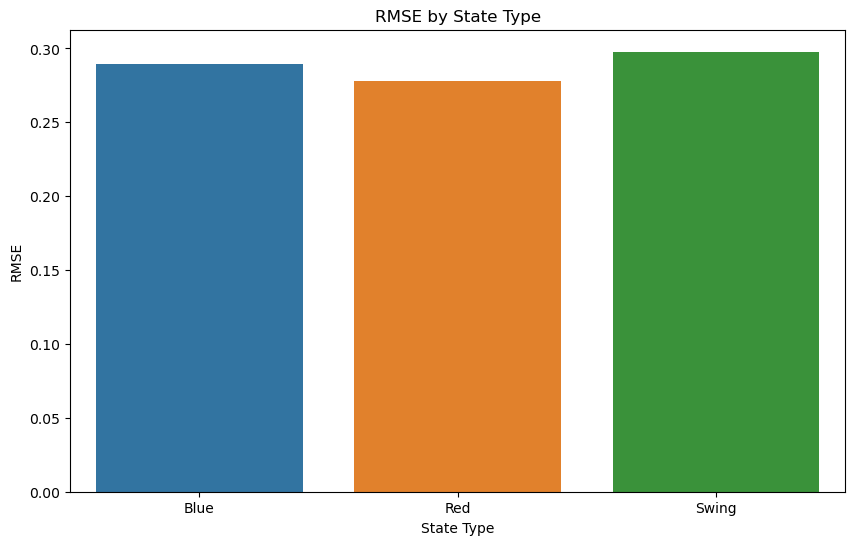

C:\Users\kalei\AppData\Local\Temp\ipykernel_53996\1031184987.py:153: FutureWarning: The provided callable <function mean at 0x000001F8AD003550> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  residuals_by_state_type = results_df.groupby('state_type').agg({'Residuals': [list, np.mean, np.std]}).reset_index()
C:\Users\kalei\AppData\Local\Temp\ipykernel_53996\1031184987.py:153: FutureWarning: The provided callable <function std at 0x000001F8AD003670> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  residuals_by_state_type = results_df.groupby('state_type').agg({'Residuals': [list, np.mean, np.std]}).reset_index()


ANOVA F-value: 0.7766859397093596
p-value: 0.46000818894143236

Demographic Parity:
   State Type  Mean Predicted Value
0       Blue            252.928440
1        Red            269.688322
2      Swing            257.785229

Equalized Odds (Residuals):
  State_Type  Mean Residual  Std Residual
0       Blue       0.161080      0.246711
1        Red       0.127744      0.262179
2      Swing       0.273099      0.167819

Predictive Parity (Mean Absolute Error):
  State Type       MAE
0       Blue  0.219350
1        Red  0.210171
2      Swing  0.273099

Data Points Count by State Type:
   State Type  Counts
0        Red    1518
1       Blue    1242
2      Swing     690
R2: 0.9136
Test RMSE: 0.2865
Cross-Validation RMSE: 0.2851 (+/- 0.1279)
Train RMSE: 0.0999
Test RMSE: 0.2865


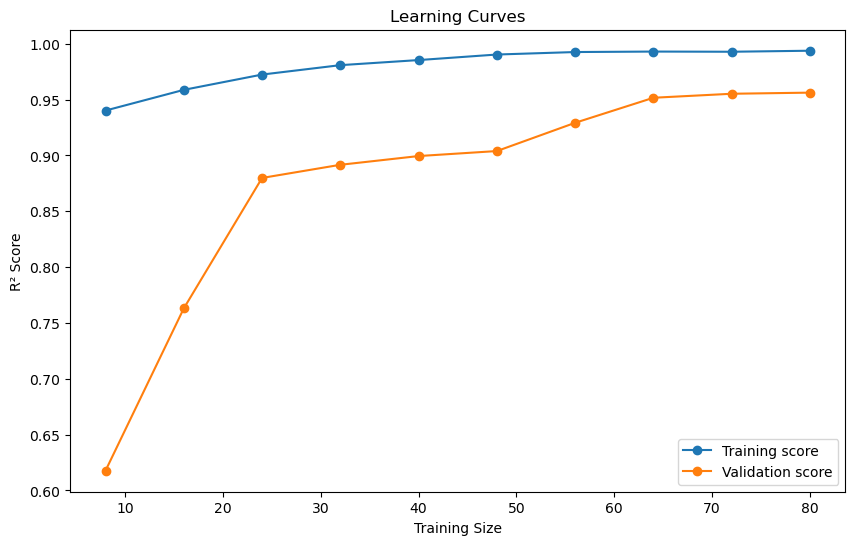

AttributeError: 'RandomForestRegressor' object has no attribute 'coef_'

In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from scipy.stats import f_oneway
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression

# Load dataset
df = pd.read_csv('processed_data/100k_population_data.csv', low_memory=False)

# Exclude territories
territories_to_exclude = ['US_GU', 'US_VI', 'US_AS', 'US_PR', 'US_MP', 'US_DC']
df = df[~df['location_key'].isin(territories_to_exclude)]

# Define state lists
blue_states_list = ['US_CA', 'US_ME', 'US_OR', 'US_CO', 'US_MD', 'US_RI', 'US_CT', 'US_MA', 'US_VT', 'US_DE', 'US_NH', 'US_VA', 'US_NJ', 'US_WA', 'US_HI', 'US_NM', 'US_NY', 'US_IL']
red_states_list = ['US_AL', 'US_AK', 'US_AR', 'US_ID', 'US_IN', 'US_IA', 'US_KS', 'US_KY', 'US_LA', 'US_MS', 'US_MO', 'US_MT', 'US_NE', 'US_ND', 'US_OK', 'US_SC', 'US_SD', 'US_TN', 'US_TX', 'US_UT', 'US_WV', 'US_WY']
swing_states_list = ['US_AZ', 'US_NV', 'US_FL', 'US_NC', 'US_GA', 'US_OH', 'US_MI', 'US_PA', 'US_MN', 'US_WI']

# Create dummy variables for state types
df['blue_states'] = df['location_key'].apply(lambda x: 1 if x in blue_states_list else 0)
df['red_states'] = df['location_key'].apply(lambda x: 1 if x in red_states_list else 0)
df['swing_states'] = df['location_key'].apply(lambda x: 1 if x in swing_states_list else 0)

# Create a state_type column
def get_state_type(row):
    if row['blue_states'] == 1:
        return 'Blue'
    elif row['red_states'] == 1:
        return 'Red'
    elif row['swing_states'] == 1:
        return 'Swing'
    else:
        return 'Other'

df['state_type'] = df.apply(get_state_type, axis=1)

# Drop unneeded columns
columns_to_drop = ['blue_states', 'red_states', 'swing_states', 'target_end_date', 'location_key', 'location', 'new_hospitalized_patients', 'hospitalized_per_100k', 'unemployment_rate', 'year', 'inc cases']

# Drop the specified columns
df = df.drop(columns=columns_to_drop)

# Dropping the nan in specific columns
df = df.dropna(subset=['new_persons_fully_vaccinated', 'vaccinated_per_100k'])

# Display dataframe
display(df)

# Split data into features (X) and target variable (y)
X = df.drop(columns=['cases_per_100k', 'total_population'])
y = df['cases_per_100k'] 

# Define smoter categorical function
def smoter_categorical(X, y, state_type, minority_class, k_neighbors=5, new_samples=100):
    # Identify minority samples based on the categorical condition
    minority_indices = np.where(state_type == minority_class)[0]
    minority_samples = X[minority_indices]
    minority_targets = y[minority_indices]
    
    # Fit nearest neighbors on minority samples
    nbrs = NearestNeighbors(n_neighbors=k_neighbors).fit(minority_samples)
    synthetic_samples = []
    synthetic_targets = []
    
    for _ in range(new_samples):
        # Randomly choose a minority sample
        idx = np.random.choice(minority_indices)
        sample = minority_samples[np.where(minority_indices == idx)[0][0]]
        target = minority_targets[np.where(minority_indices == idx)[0][0]]
        
        # Find neighbors and create a synthetic sample
        _, neighbors = nbrs.kneighbors([sample])
        neighbor_idx = neighbors[0][np.random.randint(1, k_neighbors)]
        neighbor_sample = minority_samples[neighbor_idx]
        neighbor_target = minority_targets[neighbor_idx]
        
        synthetic_sample = sample + np.random.rand() * (neighbor_sample - sample)
        synthetic_target = target + np.random.rand() * (neighbor_target - target)
        
        synthetic_samples.append(synthetic_sample)
        synthetic_targets.append(synthetic_target)
    
    # Combine original and synthetic samples
    X_res = np.vstack((X, np.array(synthetic_samples)))
    y_res = np.hstack((y, np.array(synthetic_targets)))
    
    return X_res, y_res

# Split data into features (X) and target variable (y)
X = df.drop(columns=['cases_per_100k', 'total_population'])
y = df['cases_per_100k'] 

# Generating synthetic samples and applying weightage to the state types
np.random.seed(42)
X = np.random.rand(100, 2)
y = X[:, 0] * 3 + X[:, 1] * 2 + np.random.randn(100) * 0.1
state_type = np.array(['Blue'] * 60 + ['Red'] * 30 + ['Swing'] * 10)

# Split the data
X_train, X_test, y_train, y_test, state_type_train, state_type_test = train_test_split(
    X, y, state_type, test_size=0.3, random_state=42)

# Apply custom SMOTER for categorical minority group
X_res, y_res = smoter_categorical(X_train, y_train, state_type_train, 'Blue', k_neighbors=5, new_samples=50)

# Train the model on resampled data
model = RandomForestRegressor(random_state=42)
model.fit(X_res, y_res)

# Predict the target variable for the test data
y_pred = model.predict(X_test)

# Create a DataFrame containing true target values, predicted values, and state types
y_test_df = pd.DataFrame({'cases_per_100k': y_test, 'predicted': y_pred, 'state_type': state_type_test})

# Calculate RMSE per state type
rmse_by_state_type = y_test_df.groupby('state_type').apply(lambda x: np.sqrt(mean_squared_error(x['cases_per_100k'], x['predicted']))).reset_index()
rmse_by_state_type.columns = ['State Type', 'RMSE']

# Plot RMSE by state type
plt.figure(figsize=(10, 6))
sns.barplot(x='State Type', y='RMSE', data=rmse_by_state_type)
plt.title('RMSE by State Type')
plt.xlabel('State Type')
plt.ylabel('RMSE')
plt.show()

# ANOVA F-value and p-value
f_value, p_value = f_oneway(df[df['state_type'] == 'Blue']['cases_per_100k'],
                             df[df['state_type'] == 'Red']['cases_per_100k'],
                             df[df['state_type'] == 'Swing']['cases_per_100k'])
print("ANOVA F-value:", f_value)
print("p-value:", p_value)

# Demographic Parity
demographic_parity = df.groupby('state_type')['cases_per_100k'].mean().reset_index()
demographic_parity.columns = ['State Type', 'Mean Predicted Value']
print("\nDemographic Parity:\n", demographic_parity)

# Equalized Odds (Residuals)
# Calculate residuals
residuals = y_test - y_pred

# Create a DataFrame with residuals and state_type
results_df = pd.DataFrame({'Residuals': residuals, 'state_type': state_type_test})

# Group by state_type and calculate mean and standard deviation of residuals
residuals_by_state_type = results_df.groupby('state_type').agg({'Residuals': [list, np.mean, np.std]}).reset_index()

# Rename columns for clarity
residuals_by_state_type.columns = ['State_Type', 'Residuals', 'Mean Residual', 'Std Residual']

print("\nEqualized Odds (Residuals):")
print(residuals_by_state_type[['State_Type', 'Mean Residual', 'Std Residual']])

# Predictive Parity (Mean Absolute Error)
mae_by_state_type = y_test_df.groupby('state_type').apply(lambda x: mean_absolute_error(x['cases_per_100k'], x['predicted'])).reset_index()
mae_by_state_type.columns = ['State Type', 'MAE']
print("\nPredictive Parity (Mean Absolute Error):")
print(mae_by_state_type)

# Data Points Count by State Type
data_points_count = df['state_type'].value_counts().reset_index()
data_points_count.columns = ['State Type', 'Counts']
print("\nData Points Count by State Type:\n", data_points_count)

# Evaluate the model
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Cross-validation
cv = KFold(n_splits=5, random_state=42, shuffle=True)
cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)

# Print evaluation metrics
print(f'R2: {r2:.4f}')
print(f'Test RMSE: {rmse:.4f}')
print(f'Cross-Validation RMSE: {cv_rmse_scores.mean():.4f} (+/- {cv_rmse_scores.std():.4f})')

# Check for overfitting or underfitting
train_pred = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {rmse:.4f}')

from sklearn.model_selection import learning_curve

train_sizes, train_scores, validation_scores = learning_curve(
    model, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=cv, scoring='r2')

train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', label='Training score')
plt.plot(train_sizes, validation_scores_mean, 'o-', label='Validation score')
plt.title('Learning Curves')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.legend(loc='best')
plt.show()

# Feature importance
feature_importances = model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print feature importance
print("\nFeature Importance:\n", importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

,search_trends_common_cold,stringency_index,new_persons_fully_vaccinated,average_temperature_celsius,inc cases,total_population,cases_per_100k,vaccinated_per_100k,state_type_encoded
2240,9.082857,62.500000,12102.0,5.708730,23422.0,4627047.0,506.197581,261.549105,1
2241,9.727143,61.110000,12494.0,8.451587,58334.0,7272487.0,802.119000,171.798176,2
2242,6.250000,69.440000,0.0,-2.302381,1125.0,647093.0,173.854454,0.000000,0
2243,5.881429,41.670000,2292.0,0.599206,2377.0,896299.0,265.201679,255.718237,1
2244,7.641429,54.630000,22435.0,2.499207,42903.0,9269175.0,462.856727,242.038801,0
...,...,...,...,...,...,...,...,...,...
6098,8.902857,36.110000,11608.0,22.776191,6536.0,10913150.0,59.891049,106.367089,2
6099,10.401429,33.330000,10881.0,11.180952,22726.0,6982740.0,325.459633,155.827082,0
6101,9.917143,27.780000,5160.0,9.521958,11418.0,5714300.0,199.814500,90.299774,2
6102,9.102857,30.951429,1287.0,15.607936,1726.0,1774035.0,97.292331,72.546483,1


c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


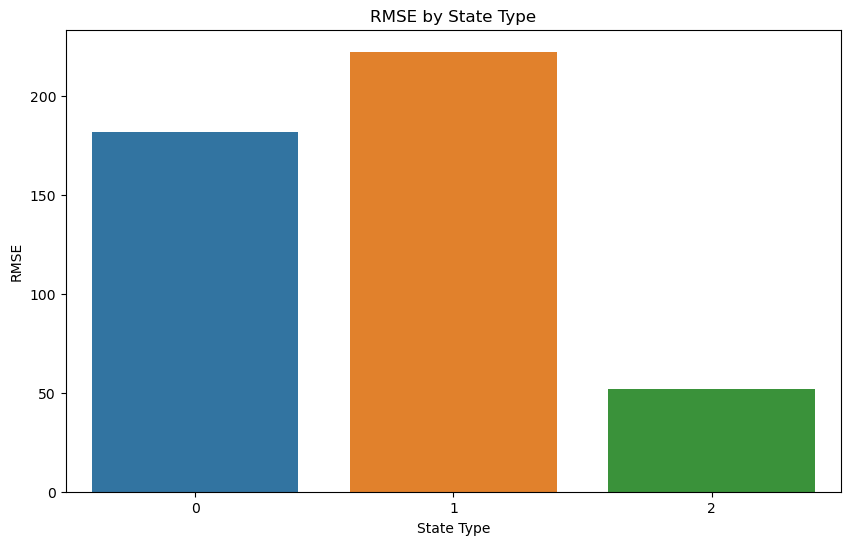

C:\Users\kalei\AppData\Local\Temp\ipykernel_53996\2893248889.py:128: FutureWarning: The provided callable <function mean at 0x000001F8AD003550> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  residuals_by_state_type = results_df.groupby('state_type').agg({'Residuals': [list, np.mean, np.std]}).reset_index()
C:\Users\kalei\AppData\Local\Temp\ipykernel_53996\2893248889.py:128: FutureWarning: The provided callable <function std at 0x000001F8AD003670> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  residuals_by_state_type = results_df.groupby('state_type').agg({'Residuals': [list, np.mean, np.std]}).reset_index()


ANOVA F-value: 0.7766859397093596
p-value: 0.46000818894143236

Demographic Parity:
   State Type  Mean Predicted Value
0       Blue            252.928440
1        Red            269.688322
2      Swing            257.785229

Equalized Odds (Residuals):
   State_Type  Mean Residual  Std Residual
0           0     -12.745660    181.457278
1           1       5.659048    222.527867
2           2       1.304529     52.147157

Predictive Parity (Mean Absolute Error):
   State Type         MAE
0           0   98.062919
1           1  115.152493
2           2   17.061754

Data Points Count by State Type:
   State Type  Counts
0        Red    1518
1       Blue    1242
2      Swing     690
R2: 0.7798
Test RMSE: 150.8625
Cross-Validation RMSE: 193.8215 (+/- 9.0926)
Train RMSE: 70.4620
Test RMSE: 150.8625

Feature Importance:
                         Feature  Importance
0     search_trends_common_cold    0.524603
3   average_temperature_celsius    0.166227
4           vaccinated_per_100k    0.13

c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


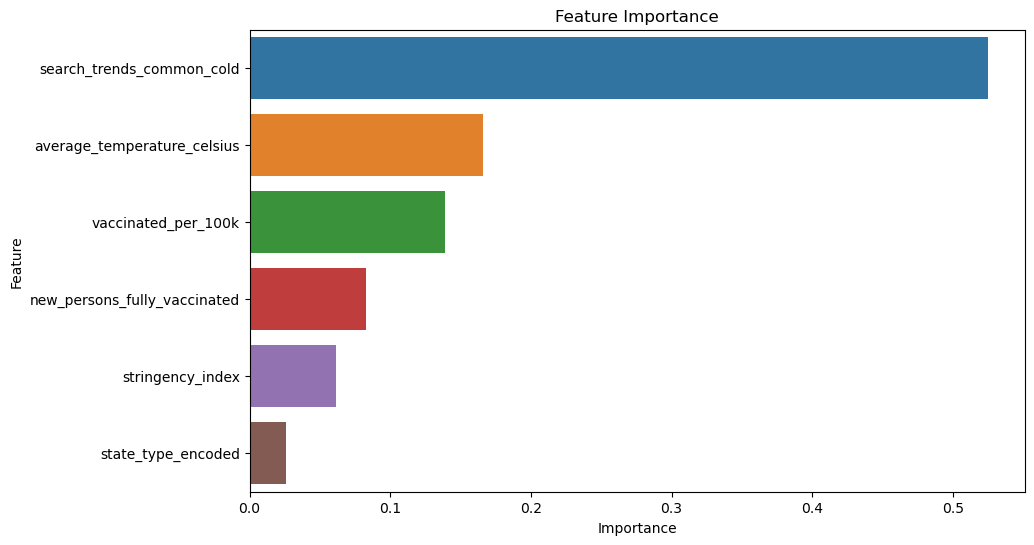

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import f_oneway
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder

# Load dataset
df = pd.read_csv('processed_data/100k_population_data.csv', low_memory=False)

# Exclude territories
territories_to_exclude = ['US_GU', 'US_VI', 'US_AS', 'US_PR', 'US_MP', 'US_DC']
df = df[~df['location_key'].isin(territories_to_exclude)]

# Define state lists
blue_states_list = ['US_CA', 'US_ME', 'US_OR', 'US_CO', 'US_MD', 'US_RI', 'US_CT', 'US_MA', 'US_VT', 'US_DE', 'US_NH', 'US_VA', 'US_NJ', 'US_WA', 'US_HI', 'US_NM', 'US_NY', 'US_IL']
red_states_list = ['US_AL', 'US_AK', 'US_AR', 'US_ID', 'US_IN', 'US_IA', 'US_KS', 'US_KY', 'US_LA', 'US_MS', 'US_MO', 'US_MT', 'US_NE', 'US_ND', 'US_OK', 'US_SC', 'US_SD', 'US_TN', 'US_TX', 'US_UT', 'US_WV', 'US_WY']
swing_states_list = ['US_AZ', 'US_NV', 'US_FL', 'US_NC', 'US_GA', 'US_OH', 'US_MI', 'US_PA', 'US_MN', 'US_WI']

# Create dummy variables for state types
df['blue_states'] = df['location_key'].apply(lambda x: 1 if x in blue_states_list else 0)
df['red_states'] = df['location_key'].apply(lambda x: 1 if x in red_states_list else 0)
df['swing_states'] = df['location_key'].apply(lambda x: 1 if x in swing_states_list else 0)

# Create a state_type column
def get_state_type(row):
    if row['blue_states'] == 1:
        return 'Blue'
    elif row['red_states'] == 1:
        return 'Red'
    elif row['swing_states'] == 1:
        return 'Swing'
    else:
        return 'Other'

df['state_type'] = df.apply(get_state_type, axis=1)

# Encode state_type to numeric values
label_encoder = LabelEncoder()
df['state_type_encoded'] = label_encoder.fit_transform(df['state_type'])

# Drop unneeded columns
columns_to_drop = ['blue_states', 'red_states', 'swing_states', 'target_end_date', 'location_key', 'location', 'new_hospitalized_patients', 'hospitalized_per_100k', 'unemployment_rate', 'year', 'state_type']
df = df.drop(columns=columns_to_drop)

# Dropping the nan in specific columns
df = df.dropna(subset=['new_persons_fully_vaccinated', 'vaccinated_per_100k'])

# Display dataframe
display(df)

# Split data into features (X) and target variable (y)
X = df.drop(columns=['cases_per_100k', 'total_population', 'inc cases'])
y = df['cases_per_100k']
state_type_encoded = df['state_type_encoded']

# Oversample minority class (e.g., Swing states)
def oversample_minority_class(X, y, state_type, minority_class):
    # Identify minority samples
    minority_indices = np.where(state_type == minority_class)[0]
    majority_indices = np.where(state_type != minority_class)[0]

    minority_samples = X.iloc[minority_indices]
    minority_targets = y.iloc[minority_indices]
    minority_state_type = state_type.iloc[minority_indices]

    # Oversample
    oversampled_minority_samples, oversampled_minority_targets, oversampled_minority_state_type = resample(
        minority_samples, minority_targets, minority_state_type, replace=True, n_samples=len(majority_indices), random_state=42
    )

    # Combine with majority samples
    X_resampled = pd.concat([X.iloc[majority_indices], oversampled_minority_samples])
    y_resampled = np.concatenate([y.iloc[majority_indices], oversampled_minority_targets])
    state_type_resampled = np.concatenate([state_type.iloc[majority_indices], oversampled_minority_state_type])

    return X_resampled, y_resampled, state_type_resampled

# Apply oversampling for Swing states
X_res, y_res, state_type_res = oversample_minority_class(X, y, state_type_encoded, label_encoder.transform(['Swing'])[0])

# Split the resampled data
X_train, X_test, y_train, y_test, state_type_train, state_type_test = train_test_split(X_res, y_res, state_type_res, test_size=0.3, random_state=42)

# Train the model on resampled data
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predict the target variable for the test data
y_pred = model.predict(X_test)

# Create a DataFrame containing true target values, predicted values, and state types
y_test_df = pd.DataFrame({'cases_per_100k': y_test, 'predicted': y_pred, 'state_type': state_type_test})

# Calculate RMSE per state type
rmse_by_state_type = y_test_df.groupby('state_type').apply(lambda x: np.sqrt(mean_squared_error(x['cases_per_100k'], x['predicted']))).reset_index()
rmse_by_state_type.columns = ['State Type', 'RMSE']

# Plot RMSE by state type
plt.figure(figsize=(10, 6))
sns.barplot(x='State Type', y='RMSE', data=rmse_by_state_type)
plt.title('RMSE by State Type')
plt.xlabel('State Type')
plt.ylabel('RMSE')
plt.show()

# ANOVA F-value and p-value
f_value, p_value = f_oneway(df[df['state_type_encoded'] == label_encoder.transform(['Blue'])[0]]['cases_per_100k'],
                            df[df['state_type_encoded'] == label_encoder.transform(['Red'])[0]]['cases_per_100k'],
                            df[df['state_type_encoded'] == label_encoder.transform(['Swing'])[0]]['cases_per_100k'])
print("ANOVA F-value:", f_value)
print("p-value:", p_value)

# Corrected Demographic Parity
demographic_parity = df.groupby('state_type_encoded')['cases_per_100k'].mean().reset_index()
demographic_parity['State Type'] = label_encoder.inverse_transform(demographic_parity['state_type_encoded'])
demographic_parity.columns = ['state_type_encoded', 'Mean Predicted Value', 'State Type']
demographic_parity = demographic_parity[['State Type', 'Mean Predicted Value']]
print("\nDemographic Parity:\n", demographic_parity)

# Equalized Odds (Residuals)
residuals = y_test - y_pred
results_df = pd.DataFrame({'Residuals': residuals, 'state_type': state_type_test})
residuals_by_state_type = results_df.groupby('state_type').agg({'Residuals': [list, np.mean, np.std]}).reset_index()
residuals_by_state_type.columns = ['State_Type', 'Residuals', 'Mean Residual', 'Std Residual']
print("\nEqualized Odds (Residuals):")
print(residuals_by_state_type[['State_Type', 'Mean Residual', 'Std Residual']])

# Predictive Parity (Mean Absolute Error)
mae_by_state_type = y_test_df.groupby('state_type').apply(lambda x: mean_absolute_error(x['cases_per_100k'], x['predicted'])).reset_index()
mae_by_state_type.columns = ['State Type', 'MAE']
print("\nPredictive Parity (Mean Absolute Error):")
print(mae_by_state_type)

# Data Points Count by State Type
data_points_count = df['state_type_encoded'].value_counts().reset_index()
data_points_count['State Type'] = label_encoder.inverse_transform(data_points_count['state_type_encoded'])
data_points_count.columns = ['state_type_encoded', 'Counts', 'State Type']
data_points_count = data_points_count[['State Type', 'Counts']]
print("\nData Points Count by State Type:\n", data_points_count)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Cross-validation
cv = KFold(n_splits=5, random_state=42, shuffle=True)
cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)

print(f'R2: {r2:.4f}')
print(f'Test RMSE: {rmse:.4f}')
print(f'Cross-Validation RMSE: {cv_rmse_scores.mean():.4f} (+/- {cv_rmse_scores.std():.4f})')

# Check for overfitting or underfitting
train_pred = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {rmse:.4f}')

# Feature importance
feature_importances = model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print feature importance
print("\nFeature Importance:\n", importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()